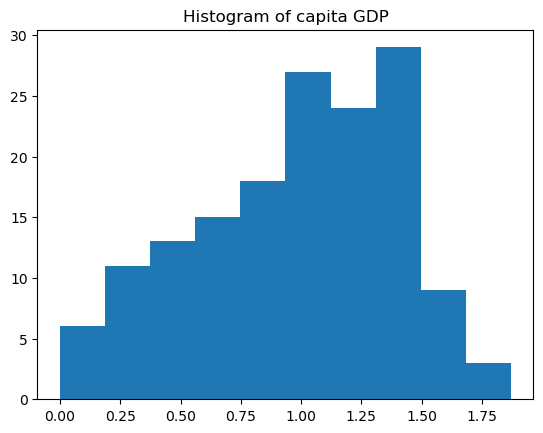

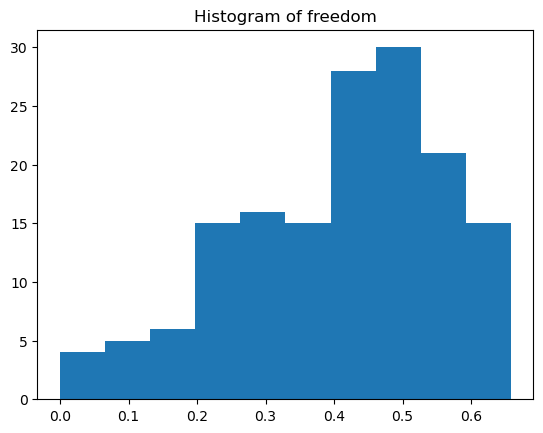

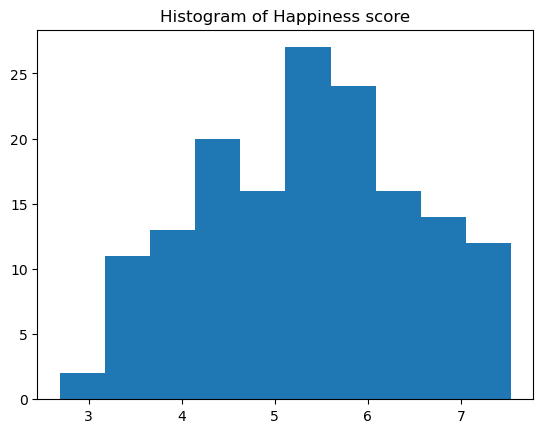

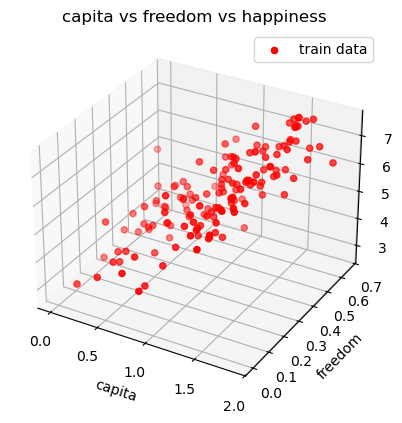

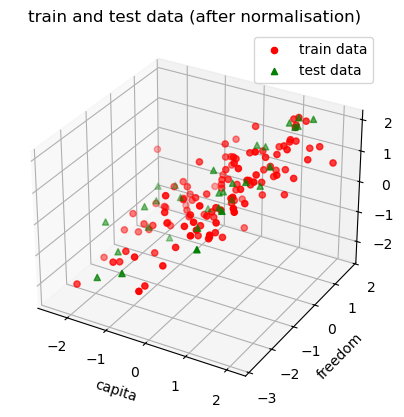

the learnt model: f(x) = 4.211657075318019e-05 + 0.6421181430558311 * x1 + 0.3034056692718725 * x2


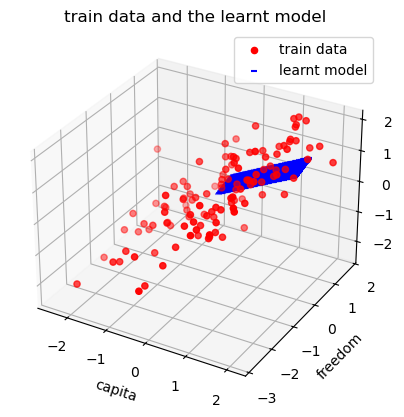

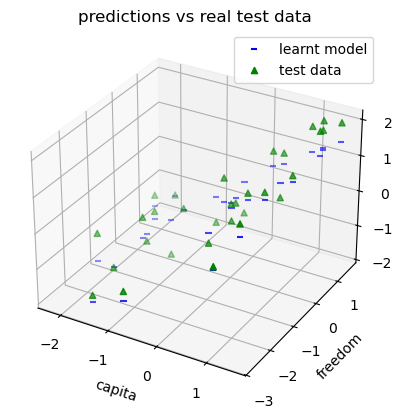

prediction error (tool):  0.232184828805282


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from skimage.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


def load_data(file_name, input_var, output_var):
    data = []
    data_names = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for i, row in enumerate(csv_reader):
            if i == 0:
                data_names = row
            else:
                data.append(row)
    selected_input1 = data_names.index(input_var[0])
    selected_input2 = data_names.index(input_var[1])
    selected_output = data_names.index(output_var)
    inputs_load = [[float(data[i][selected_input1]), float(data[i][selected_input2])] for i in range(len(data))]
    outputs_load = [float(data[i][selected_output]) for i in range(len(data))]
    return inputs_load, outputs_load


def plot_histogram(x, var):
    plt.hist(x, 10)
    plt.title('Histogram of ' + var)
    plt.show()


def plot_3d(x1_train=None, x2_train=None, y_train=None,
            x1_model=None, x2_model=None, y_model=None,
            x1_test=None, x2_test=None, y_test=None,
            title=None):
    ax = plt.axes(projection='3d')

    def is_valid(x): return x is not None and len(x) > 0

    if is_valid(x1_train):
        ax.scatter(x1_train, x2_train, y_train, c='r', marker='o', label='train data')
    if is_valid(x1_model):
        ax.scatter(x1_model, x2_model, y_model, c='b', marker='_', label='learnt model')
    if is_valid(x1_test):
        ax.scatter(x1_test, x2_test, y_test, c='g', marker='^', label='test data')

    ax.set_xlabel("capita")
    ax.set_ylabel("freedom")
    ax.set_zlabel("happiness")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


def normalisation(train_data, test_data):
    scaler = StandardScaler()
    if not isinstance(train_data[0], list):
        train_data = [[d] for d in train_data]
        test_data = [[d] for d in test_data]
        normalised_td = scaler.fit_transform(train_data)
        normalised_tstd = scaler.transform(test_data)
        normalised_td = [el[0] for el in normalised_td]
        normalised_tstd = [el[0] for el in normalised_tstd]
    else:
        normalised_td = scaler.fit_transform(train_data).tolist()
        normalised_tstd = scaler.transform(test_data).tolist()
    return normalised_td, normalised_tstd


file = '../data/world-happiness-report-2017.csv'
inputs, outputs = load_data(file, ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')

feature1 = [ex[0] for ex in inputs]
feature2 = [ex[1] for ex in inputs]

plot_histogram(feature1, 'capita GDP')
plot_histogram(feature2, 'freedom')
plot_histogram(outputs, 'Happiness score')

plot_3d(feature1, feature2, outputs, None, None, None, None, None, None, 'capita vs freedom vs happiness')

np.random.seed(5)
indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
testSample = [i for i in indexes if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]
testInputs = [inputs[i] for i in testSample]
testOutputs = [outputs[i] for i in testSample]

trainInputs, testInputs = normalisation(trainInputs, testInputs)
trainOutputs, testOutputs = normalisation(trainOutputs, testOutputs)

feature1train = [ex[0] for ex in trainInputs]
feature2train = [ex[1] for ex in trainInputs]
feature1test = [ex[0] for ex in testInputs]
feature2test = [ex[1] for ex in testInputs]

plot_3d(feature1train, feature2train, trainOutputs, None, None, None, feature1test, feature2test, testOutputs,"train and test data (after normalisation)")

regressor = linear_model.SGDRegressor(max_iter=1000, eta0=0.01, learning_rate='constant', shuffle=False, average=True, tol=1e-6)
regressor.fit(trainInputs, trainOutputs)

w0, w1, w2 = regressor.intercept_[0], regressor.coef_[0], regressor.coef_[1]
print(f'the learnt model: f(x) = {w0} + {w1} * x1 + {w2} * x2')

noOfPoints = 50
x_vals = np.linspace(min(feature1), max(feature1), noOfPoints)
y_vals = np.linspace(min(feature2), max(feature2), noOfPoints)
xref1, xref2 = np.meshgrid(x_vals, y_vals)
xref1_flat = xref1.flatten()
xref2_flat = xref2.flatten()
yref = [w0 + w1 * x + w2 * y for x, y in zip(xref1_flat, xref2_flat)]

plot_3d(feature1train, feature2train, trainOutputs, xref1_flat, xref2_flat, yref, None, None, None,
        'train data and the learnt model')

computedTestOutputs = regressor.predict(testInputs)

plot_3d(None, None, None, feature1test, feature2test, computedTestOutputs, feature1test, feature2test, testOutputs,
        'predictions vs real test data')

error = mean_squared_error(np.array(testOutputs), np.array(computedTestOutputs))
print('prediction error (tool): ', error)